In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

### Andmete laadimine

In [4]:
with open("../config/marc_columns_to_keep.json", "r", encoding="utf8") as f:
    columns = json.load(f)["columns"]

with open("../config/marc_columns_dict.json", "r", encoding="utf8") as f:
    column_names = json.load(f)
    column_names_reverse = {val: key for key, val in column_names.items()}
    column_names_verbose = {key: f"{key}: {val}" for key, val in column_names.items()}

In [5]:
df_main = pd.read_csv("../data/interim/erb_books.tsv", sep="\t", encoding="utf8")

C:\Users\krister.kruusmaa\AppData\Local\Temp\ipykernel_12212\2810970634.py:1: DtypeWarning: Columns (4,27,61,66,84,90,92,93,94,95,96,97,98,99,100,101,102,103,104,105,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv("../data/interim/erb_books.tsv", sep="\t", encoding="utf8")


In [6]:
df_main = df_main[columns]
df_main.head()

,001,020$a,041$a,041$h,080$a,100,245$a,245$b,245$n,246$a,...,655$a,655$0,700,710$a,710$b,740$a,752$c,752$d,776$i,856$u
0,b10500820,9789916099896,NaN,NaN,821.511.113-31,"Tammsaare, A. H (1878-1940) [autor]",Tõde ja õigus,romaan,1. [kd.],NaN,...,ilukirjandus (vormimärksõna); romaanid (vormim...,https://ems.elnet.ee/id/EMS002472; https://ems...,"Eelma, Herald (1934-) [illustreerija]",NaN,NaN,NaN,NaN,NaN,NaN,http://www.digar.ee/id/nlib-digar:829637
1,b10258747,9186116800,NaN,NaN,94; 355.48,"Laar, Mart (1960-) [autor]",Isamaa ilu hoieldes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b10501915,9789916015346,NaN,NaN,17.036; 141.82,"Makarov, Mihhail (1922-2019) [autor]",Eesmärk ja vahendid,NaN,NaN,NaN,...,NaN,NaN,"Tali, Erich (1921-1990) [kujundaja]",NaN,NaN,NaN,NaN,NaN,NaN,http://www.digar.ee/id/nlib-digar:447419
3,b10509884,5450023782,est,eng,821.111,"Buck, Pearl S (1892-1973) [autor]",Ema,romaan,NaN,Mother,...,ilukirjandus (vormimärksõna); romaanid (vormim...,https://ems.elnet.ee/id/EMS002472; https://ems...,"Hanko, August (1879-1952) [tõlkija]; Linnamägi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b10505283,5440008519,est,NaN,581.9; 591.9; 913,NaN,Ruhnu saare loodus =,Nature of the Ruhnu island = Природа острова Р...,NaN,Nature of the Ruhnu island; Природа острова Рухну,...,artiklikogumikud (vormimärksõna),https://ems.elnet.ee/id/EMS026849,"Talvi, Tõnu (1962-) [toimetaja]",Eesti Looduseuurijate Selts,NaN,NaN,NaN,NaN,NaN,NaN


### Abifunktsioonid

In [5]:
def roman_to_arabic(roman):
    # Mapping of Roman numerals to Arabic numerals
    roman_numerals = {
        'I': 1,
        'V': 5,
        'X': 10,
        'L': 50,
        'C': 100,
        'D': 500,
        'M': 1000
    }
    
    # Initialize the previous value and total
    prev_value = 0
    total = 0
    
    # Reverse the Roman numeral string for left-to-right calculation
    for char in reversed(roman):
        value = roman_numerals[char]
        
        # If the current value is less than the previous one, subtract it from the total; else add it
        if value < prev_value:
            total -= value
        else:
            total += value
        
        # Update the previous value
        prev_value = value
    
    return total

In [6]:
def missing_values_heatmap(df, verbose=True):
    plt.figure(figsize=(6,4))
    df_hm = df.copy()
    if verbose:
        df_hm = df_hm.rename(columns=column_names_verbose)

    print("Täidetus:")
    for col in df_hm.columns:
        print(f"{col}: {round((df_hm[col].notna().sum()/len(df_hm))*100)} %")
    sns.heatmap(df_hm.isna(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title("Puuduvad väärtused")
    plt.show()

In [7]:
def regex_coverage(df, col, pattern):
    total_entries = len(df.loc[df[col].notna()])
    covered_values = 0
    for entry in df.loc[df[col].notna(), col].values:
        if re.search(pattern, entry):
            covered_values += 1

    print(f"Regex katab {covered_values} kirjet {total_entries} kirjest")
    print("Kaetus: ", round(covered_values/total_entries*100, 2), "%")

## Tulpade analüüs ja puhastamine

### ISBN (020a)

In [167]:
df = df_main["020$a"].copy()

In [168]:
df.sample(10)

182068    9789949258321
209246    9789916407486
68111               NaN
169166    9789985327104
105311              NaN
12600     9789916044568
37109     9789949797523
81684               NaN
158828    9789985998274
35426               NaN
Name: 020$a, dtype: object

Täidetus:
020$a: ISBN: 62 %


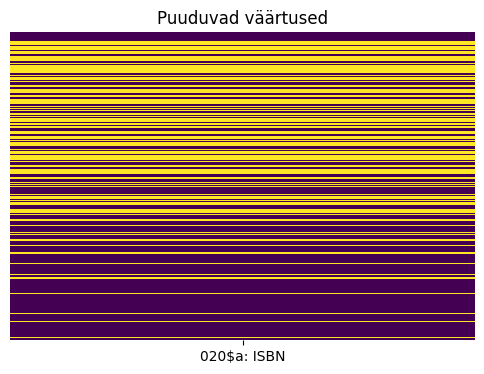

In [169]:
missing_values_heatmap(df.to_frame())

In [170]:
import isbnlib

In [235]:
### testime ISBN-ide valideerimist
def validate_020(entry):
    try:
        if type(entry) == str:
            entry_split = np.array(entry.split("; "))
            valid_isbns = []
            for code in entry_split:
                code = isbnlib.clean(code)
                if isbnlib.is_isbn10(code):
                    valid_isbns.append(code)
                elif isbnlib.is_isbn13(code):
                    valid_isbns.append(code)
            return "; ".join(valid_isbns)#.replace("  ", " ")
        else:
            #print(entry, "not string")
            return None
    except:
        print(f"Could not process", entry)

In [236]:
#df = df.to_frame()
df["020$a_cleaned"] = df["020$a"].apply(validate_020)
df = df.convert_dtypes()
df.sample(10)

,020$a,020$a_cleaned
183914,9789949977208,9789949977208
42148,<NA>,<NA>
172919,9789949340897,9789949340897
216680,9789916125588,9789916125588
64397,9789916584903,9789916584903
66891,9789916213674,9789916213674
22358,<NA>,<NA>
65551,9985591356,9985591356
11774,<NA>,<NA>
134350,9985961757; 9789985961759,9985961757; 9789985961759


In [239]:
print('Kokku ISBN-iga kirjeid: ', len(df.loc[df["020$a"].notna()]))
print('Kirjeid, kus ISBN pole (tervenisti) valiidne: ', len(df.loc[df["020$a"] != df["020$a_cleaned"]]))
print('Valiidsete ISBN kirjete osakaal: ', round(len(df.loc[df["020$a"] == df["020$a_cleaned"]]) / len(df.loc[df["020$a"].notna()]), 3)*100, "%")

Kokku ISBN-iga kirjeid:  136569
Kirjeid, kus ISBN pole (tervenisti) valiidne:  370
Valiidsete ISBN kirjete osakaal:  99.7 %


### Keel, originaalkeel ja keelemärkus (041 a, h; 546a)

In [ ]:
df = df_main[["041$a", "041$h", "546$a"]].copy()

Täidetus:
041$a: language: 38 %
041$h: language_original: 29 %
546$a: language_note: 10 %


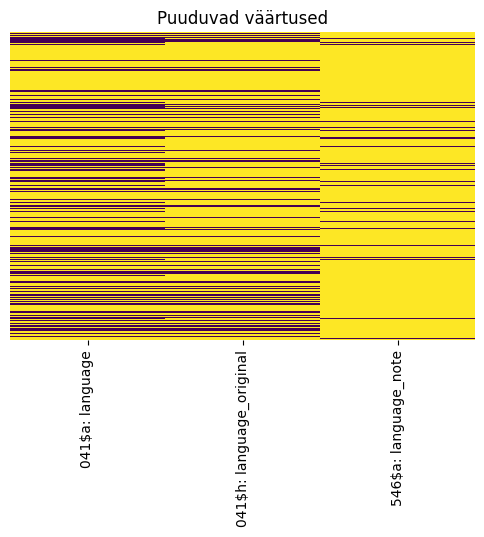

In [ ]:
missing_values_heatmap(df)

In [ ]:
### tundub, et tõlketeostel on alati kirjas mõlemad keeled, st koos originaalkeelega täidetakse keel
print(f'Kirjeid, kus pole originaalkeelt, aga on keel: {len(df.loc[(df["041$a"].notna()) & (df["041$h"].isna())])}')
print(f'Kirjeid, kus pole keelt, aga on originaalkeel: {len(df.loc[(df["041$a"].isna()) & (df["041$h"].notna())])}')

Kirjeid, kus pole originaalkeelt, aga on keel: 20573
Kirjeid, kus pole keelt, aga on originaalkeel: 0


In [ ]:
df = df_main[["100", "700", "245$a", "246$a", "041$a", "041$h", "546$a"]].copy()

In [ ]:
df.loc[df["041$a"].notna()].sample(10)

,100,700,245$a,246$a,041$a,041$h,546$a
591,"Pütsep, Ervin (1921-1995) [autor]","Tarvel, Enn (1932-2021) [eessõna autor]",Kunstielu Eestimaal,NaN,est,NaN,Kokkuvõte inglise keeles
149510,NaN,NaN,Veel kõike kõigest,NaN,est,eng,NaN
194498,NaN,NaN,Tegevusvihik eelkooliealistele,NaN,est,rus,NaN
47848,NaN,"Talts, Anne (1940-2020) [koostaja]; Järs, Jüri...",1982. aastaks tellitud harukondlike infoorgani...,"Серии отраслевых органов информации, выписанны...",rus,NaN,Tekst eesti ja vene keeles
27823,"Vaga, Alfred (1895-1980) [autor]",NaN,Ferdi Sannamees,F. Sannamees,est,NaN,Kokkuvõte prantsuse keeles
156108,"Perälä, Rae [autor]","Perema, Anne [tõlkija]; Perälä, Osmo (1945-) [...",Soojuspumbad,Lämpöpumput,est,fin,NaN
58489,"Heald, George H [autor]","Ruble, Wells A [autor]; Krikberg, Rudolf [tõlk...",Rahwahaigused,Rahvahaigused,est,eng,NaN
217457,"Webb, Jonice [autor]","Ugur, Kadri (1966-) [tõlkija]",Üksindusest ühenduseni,NaN,est,eng,NaN
83670,"Goethe, Johann Wolfgang von (1749-1832) [autor]","Oras, Ants (1900-1982) [tõlkija]; Oras, Ants (...",Faust,NaN,est,ger,NaN
139811,"Enzensberger, Hans Magnus (1929-2022) [autor]","Kangro, Maarja (1973-) [tõlkija]; Kangro, Maar...",Tõmba sobimatu maha,NaN,est,ger,NaN


In [ ]:
### vaatame, mis on levinumad keeled nendel kirjetel, kus on ainult keel
df.loc[(df["041$a"].notna()) & (df["041$h"].isna())]["041$a"].value_counts()[:20]

est    7396
rus    7001
eng    3244
ger    1247
fin     409
fre     277
lat     268
swe     239
mul      97
lav      72
epo      37
spa      31
hun      28
ita      28
pol      17
lit      17
gre      15
nor      12
jpn      11
vot      10
Name: 041$a, dtype: int64

#### Keelemärkus (546a)

In [ ]:
### kas on mõtet neid kuidagi ühtlustada? nt:
### rööptekst inglise ja vene keeles -> eng, rus [rööptekst]
### Osa teksti prantsuse keeles -> fre [osa teksti]
df_main["546$a"].value_counts()[:30]

Rööptekst vene keeles                          3014
Kokkuvõte inglise keeles                       2360
Rööptekst inglise keeles                       2217
Osa teksti vene keeles                         1210
Kokkuvõte saksa keeles                          730
Osa teksti inglise keeles                       608
Tekst eesti ja vene keeles                      459
Tõlgitud vene keelest                           369
Kokkuvõte vene keeles                           337
Rööptekst vene ja eesti keeles                  333
Artiklite kokkuvõtted inglise keeles            316
Rööptekst saksa keeles                          308
Sisukord ka vene keeles                         294
Tekst eesti ja inglise keeles                   238
Rööptekst inglise ja vene keeles                204
Osa teksti saksa keeles                         187
Kokkuvõte inglise ja vene keeles                185
Rööpsisukord vene keeles                        156
Rööptekst vene ja inglise keeles                153
Kokkuvõte pr

### Pealkiri ja alapealkiri (245 a, b, n)

In [50]:
### vaatame üle nende tulpade kaetuse

df = df_main[["245$a", "245$b", "245$n"]].copy()

Täidetus:
245$a: title: 100 %
245$b: title_remainder: 54 %
245$n: title_part_nr: 8 %


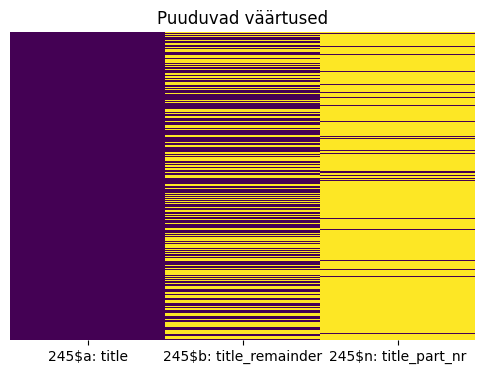

In [51]:
missing_values_heatmap(df)

In [409]:
### OTSUS: ühtlustada 245$n regexi abil

In [27]:
# võtame 2000 sagedasemat väärtust
sample_values = df["245$n"].value_counts()[:2000].index

In [53]:
# regex pattern
pattern_245n = r"(?:([Nn]r\.?\s)|Album\s|Triloogia\s)?(?P<n>(?P<araabia>\d{1,2})|(?P<rooma>\b(?=[MDCLXVI]+\b)(M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3}))\b)|(?P<arvsna>(?P<a1>[Ee]{1,2}[sd]{1,2}i?m[eaä]n{1,2}e)|(?P<a2>[Tt][eõö]ine)|(?P<a3>[Kk]olmas)|(?P<a4>[Nn]eljas)|(?P<a5>[VWvw]i{1,2}es)|(?P<a6>[Kk]u{1,2}es)|(?P<a7>[Ss]eitsmes)|(?P<a8>[Kk]ah{1,2}eksas)|(?P<a9>[Üü]h{1,2}eksas)|(?P<a11>([Üü](ks|he)teist)|(?P<a12>[Kk]a(ks|he)teist))?(?P<a10>[Kk]ümnes))|(?P<AB>A|B))(\.)?\s?(?P<p>(?:\[?)([A-zöõäü]+)(?:\.?\]?))?"

In [54]:
# katsetame kaetuse protsenti
print(f"Regex katab {df['245$n'].value_counts()[:2000].sum()} kirjet {len(df.loc[df['245$n'].notna()])} kirjest")
print("Kaetus: ", round((df["245$n"].value_counts()[:2000].sum()/len(df.loc[df["245$n"].notna()]))*100, 2), "%")

Regex katab 18029 kirjet 18088 kirjest
Kaetus:  99.67 %


In [55]:
# millised jäävad katmata?

for entry in sample_values:
    match = re.search(pattern=pattern_245n, string=entry)
    if match:
        # print("\n")
        # print(entry)
        # print(match.groupdict())
        pass
    else:
        print(entry)

NameError: name 'sample_values' is not defined

In [56]:
def clean_245n(entry: str, pattern=pattern_245n):
    
    if type(entry) == str:
        match = re.search(pattern, entry)
        if match:
            groups = match.groupdict()
            n = None
            p = None

            if groups["n"]:
                if groups["araabia"]:
                    n = groups["araabia"]
                elif groups["rooma"]:
                    n = str(roman_to_arabic(groups["rooma"]))
                elif groups["arvsna"]:
                    for key, val in groups.items():
                        if re.search("a\d{1,2}", key):
                            if val is not None:
                                n = key.lstrip("a")
                                break
                elif groups["AB"]:
                    if groups["AB"] == "A":
                        n = "1"
                    elif groups["AB"] == "B":
                        n = "2"
                    
            if groups["p"]:
                p = f" [{groups['p'].lstrip('[').strip(']')}]"
            else:
                p = ''

            #print(groups)
            return n+p

In [70]:
# näited
sample = df["245$n"].loc[df["245$n"].notna()].sample().values[0]
print(sample, "\t-\t", clean_245n(sample, pattern_245n))

1. vihik 	-	 1 [vihik]


**TODO**: 1-3, III-IV jne, I ja II, 3 ja 4

### Koht, aeg, kirjastus dubleerimise kaotamine (260 a, b, c vs 264 a, b c)

**Probleem**: mingil hetkel 2022. aasta jooksul hakati 260 asemel kasutama 264.

In [71]:
df = df_main[["260$a", "260$b", "260$c", "264$a", "264$b", "264$c"]].copy()

Täidetus:
260$a: publication_place: 96 %
260$b: publisher: 95 %
260$c: publication_date: 96 %
264$a: production_publication_distribution_place: 4 %
264$b: producer_publisher_distributer_name: 4 %
264$c: production_publication_distribution_date: 4 %


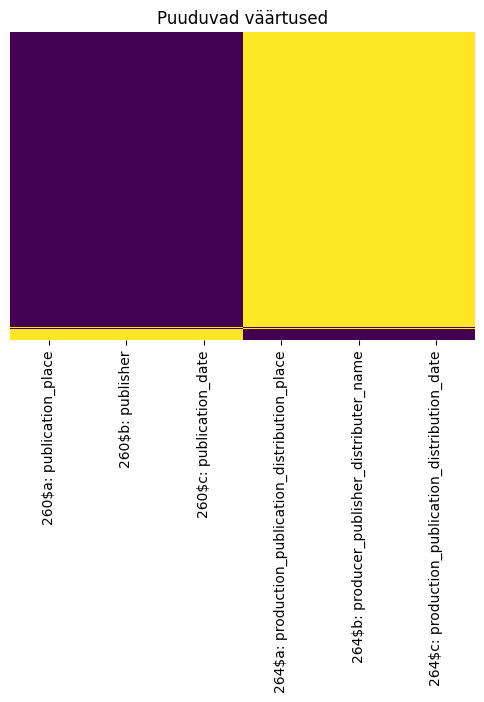

In [72]:
missing_values_heatmap(df)

In [73]:
### igaks juhuks topelkontroll, ega pole kirjeid, kus on täidetud nii 260 kui 264

for sub in ["a", "b", "c"]:
    rows_with_values_in_both_columns = df[df[f'260${sub}'].notna() & df[f'264${sub}'].notna()]
    print("260", sub, "topeltkirjete arv:", len(rows_with_values_in_both_columns))

260 a topeltkirjete arv: 0
260 b topeltkirjete arv: 0
260 c topeltkirjete arv: 0


In [74]:
### kuna väärtus on alati kas ainult 260 või 264 peal, siis jääb üle need lihtsalt kokku tõsta. Jätame alles väljad 260 ja täiendame neid väljadega 264
def add_260abc_264abc(df):
    for sub in ["a", "b", "c"]:
        df[f"260${sub}"] = df[f"260${sub}"].fillna(df[f"264${sub}"])

add_260abc_264abc(df)

### Aastaarvude puhastamine (260c)

In [78]:
# peab tegelema sellist sorti eranditega
yr = df["260$c"].copy()
yr = yr[yr.notna()]
for i in yr[~yr.str.contains(r"^\d{4}$", na=False)].sample(10):
    print(i)

c2002
c2020
c2016
c2009
c2003
c2013
193-?
c2010
c2008
c2016


In [79]:
pattern_260c = re.compile(r"(?:c|(?P<copyright>©)|tsens(eeritud|\.)\s*)?((?P<year>\d{4})(?:\.0)?(?:\?)?|(?P<decade>\d{3}-\?)|(?P<century>\d{2}--\?))")

In [80]:
def clean_260c(entry, pattern=pattern_260c, min_year=1500, max_year=2024):
    """Funktsioon võtab sisse välja 260$c ehk ilmumisaasta kirje ning tagastab aasta ning kümnendi arvulisel kujul."""
    output_year = None
    output_decade = None
    # output_century = None

    if type(entry) != str:
        entry = str(entry)

    # 2022; 2022    
    if ";" in entry:
        entry_split = entry.split("; ")
        years = []
        for part in entry_split:
            match = re.search(pattern, part)
            if match:
                part_year = match.groupdict()["year"]
                if part_year is not None:
                    if part_year not in years:
                        if match.groupdict()["copyright"] is None:
                            years.append(part_year)
                        else:
                            if len(years) == 0:
                                years.append(part_year)

        if len(years) == 1:
            output_year = int(years[0])
        else:
            output_year = min([int(y) for y in years])

    else:
        match = re.search(pattern, entry)
        if match:
            groups = match.groupdict()
            # 2022
            if groups["year"] is not None:
                output_year = int(groups["year"])
            # 196-?
            elif groups["decade"] is not None:
                output_decade = int(groups["decade"].strip("?").replace("-", "0"))
            # 18--?
            # elif groups["century"] is not None:
            #     output_century = int(groups["century"].strip("?").replace("-", "0"))

    if output_year:
        if output_year in range(min_year, max_year+1):
            output_decade = output_year // 10 * 10
            # output_century = output_year // 100 * 100
        else:
            output_year = None

    # elif output_decade:
    #     output_century = output_decade // 10 * 10

    return (output_year, output_decade)


In [81]:
df[["260$c_cleaned", "decade"]] = df["260$c"].apply(clean_260c).to_list()
df = df.convert_dtypes()

In [94]:
df[["260$c", "260$c_cleaned", "decade"]].sample(10)

,260$c,260$c_cleaned,decade
68137,1969,1969,1960
140902,1928,1928,1920
168943,c2013,2013,2010
147390,192-?,<NA>,1920
166717,2012,2012,2010
111311,2002,2002,2000
110622,1861,1861,1860
212117,2022; ©2022,2022,2020
118826,1998?,1998,1990
142742,1936,1936,1930


In [872]:
# ebastandardsemaid näiteid
sample = yr[~yr.str.contains(r"^\d{4}$", na=False)].sample(10)
cleaned_sample = sample.apply(clean_260c)

for s, c in zip(sample, cleaned_sample):
    print(s, "\t\t", c)

c2018 		 (2018, 2010)
c2007 		 (2007, 2000)
c2003 		 (2003, 2000)
c2005 		 (2005, 2000)
c2002 		 (2002, 2000)
c2017 		 (2017, 2010)
c2017 		 (2017, 2010)
c2011 		 (2011, 2010)
c2020 		 (2020, 2020)
c2013 		 (2013, 2010)


In [871]:
# millised jäävad katmata?
for val in df["260$c"].values:
    val_cleaned = clean_260c(val)
    if val_cleaned == (None, None):
        if val is not None:
            print(val, "\t\t", val_cleaned)
# nagu näha, siis need, mis on vaid sajandi täpsusega (19--?), ja vigased kanded

19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
18--? 		 (None, None)
19--? 		 (None, None)
J. Felsberg ja A. Tetermann 		 (None, None)
J. F. Steffenhagen und Sohn 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
18--? 		 (None, None)
19--? 		 (None, None)
18--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
1291 [p.o. 1921] 		 (None, None)
1291 [p.o. 1921] 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
Tallinn 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
[19--?] ( 		 (None, None)
19--? 		 (None, None)
19--

### 3. Füüsilised omadused (300 a, b, c)

In [95]:
df = df_main[["300$a", "300$b", "300$c"]].copy()

Täidetus:
300$a: physical_extent: 99 %
300$b: physical_details: 53 %
300$c: physical_dimensions: 90 %


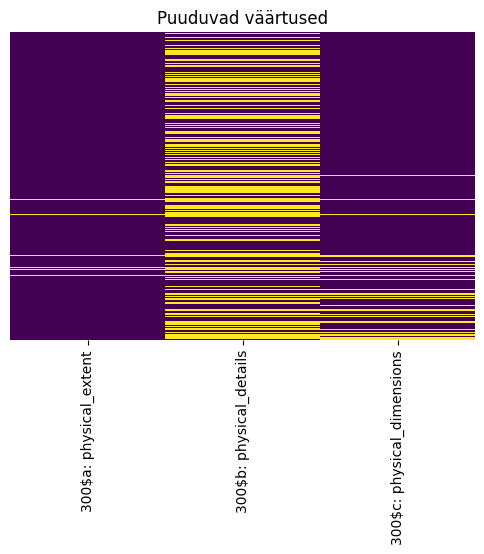

In [96]:
missing_values_heatmap(df)

In [407]:
### kuna tegu on väga hästi täidetud tulpadega, võiks need regexiga ära puhastada ja vajadusel eraldi tulpadeks lahku lüüa

#### 300$a

In [97]:
### teeme sellest tulbast konkreetselt lehekülgede arvu tulba, st võtame välja lk arvu seal, kus võimalik. e-raamatud ja võrguväljaanded jätame hetkel kõrvale.
df["300$a"].value_counts()[:10]

1 võrguväljaanne (epub)    5165
16 lk                      3010
32 lk                      2621
1 võrguressurss (epub)     2349
1 e-raamat                 2254
64 lk                      1947
24 lk                      1829
48 lk                      1795
8 lk                       1491
96 lk                      1447
Name: 300$a, dtype: int64

In [98]:
pattern_300a = re.compile(r"(?P<arv>\[?\d{1,4}\]?),?(\s*)?(?P<sulud>\[\d+\])?\s+(?P<uhik>lk|l\b|(nummerdamata\s)?lehekülge|voldik|CD-ROM|(võrgu(väljaanne|ressurss)|e-raamat))")

In [99]:
# testime kaetust
regex_coverage(df, "300$a", pattern_300a)

Regex katab 214366 kirjet 216836 kirjest
Kaetus:  98.86 %


In [100]:
# millised jäävad katmata?
sample_values = df["300$a"].value_counts()[:200].index
for entry in sample_values:
    match = re.search(pattern=pattern_300a, string=entry)
    if match:
        print("\n")
        print(entry)
        print(match.groupdict())
        pass
    else:
        print(entry)



1 võrguväljaanne (epub)
{'arv': '1', 'sulud': None, 'uhik': 'võrguväljaanne'}


16 lk
{'arv': '16', 'sulud': None, 'uhik': 'lk'}


32 lk
{'arv': '32', 'sulud': None, 'uhik': 'lk'}


1 võrguressurss (epub)
{'arv': '1', 'sulud': None, 'uhik': 'võrguressurss'}


1 e-raamat
{'arv': '1', 'sulud': None, 'uhik': 'e-raamat'}


64 lk
{'arv': '64', 'sulud': None, 'uhik': 'lk'}


24 lk
{'arv': '24', 'sulud': None, 'uhik': 'lk'}


48 lk
{'arv': '48', 'sulud': None, 'uhik': 'lk'}


8 lk
{'arv': '8', 'sulud': None, 'uhik': 'lk'}


96 lk
{'arv': '96', 'sulud': None, 'uhik': 'lk'}


20 lk
{'arv': '20', 'sulud': None, 'uhik': 'lk'}


40 lk
{'arv': '40', 'sulud': None, 'uhik': 'lk'}


80 lk
{'arv': '80', 'sulud': None, 'uhik': 'lk'}


15 lk
{'arv': '15', 'sulud': None, 'uhik': 'lk'}


56 lk
{'arv': '56', 'sulud': None, 'uhik': 'lk'}


12 lk
{'arv': '12', 'sulud': None, 'uhik': 'lk'}


1 võrguväljaanne (pdf)
{'arv': '1', 'sulud': None, 'uhik': 'võrguväljaanne'}


15, [1] lk
{'arv': '15', 'sulud': '[1]'

In [101]:
def clean_300a(entry: str, pattern=pattern_300a):
    
    if type(entry) == str:
        match = re.search(pattern, entry)
        if match:
            groups = match.groupdict()
            lk = None

            if groups["arv"]:
                if groups["uhik"]:
                    if groups["uhik"] in ["l", "lk", "lehekülge", "nummerdamata lehekülge"]:
                        lk = int(groups["arv"].lstrip("[").strip("]"))

            # print(groups)
            return lk

In [117]:
# näited
sample = df["300$a"].loc[df["300$a"].notna()].sample().values[0]
print(sample, "\t-\t", clean_300a(sample, pattern_300a))

157, [1] lk 	-	 157


In [262]:
df["300$a_cleaned"] = df["300$a"].apply(clean_300a)
df = df.convert_dtypes()

In [268]:
df.sample(10)

,300$a,300$b,300$c,300$a_cleaned
191570,1 e-raamat (epub),<NA>,<NA>,<NA>
74738,"Lk. 206-275, [1]",joon,20 cm,<NA>
175495,51 lk,<NA>,23 cm,51
184394,"1 võrguväljaanne (54 lk., pdf)",ill,<NA>,<NA>
145531,"191, [1] lk",<NA>,21 cm,191
134634,"283, [5] lk",ill,25 cm,283
42169,82 lk,<NA>,14 cm,82
161342,"[16] lk., [2] l. kleeppilte, [2] l. kujundeid",ill,27 cm,16
32155,"134, [1] lk",<NA>,20 cm,134
34103,119 lk,ill,20 cm,119


#### 300$b

In [118]:
### tundub, et selle tulba võib teha lihtsalt 1/0 tulbaks - kui midagi on märgitud, siis on raamat illustreeritud
df["300$b"].value_counts()[:10]

ill                 80868
ill., portr         10670
ill. kaas            4182
illustratsioonid     3940
portr                2664
ill., ill. kaas      2582
ill., kaart          2185
joon                  977
fot                   916
ill., noot            740
Name: 300$b, dtype: int64

In [119]:
def clean_300b(entry):
    if type(entry) == str:
        return True
    else:
        return False

In [120]:
df["300$b_cleaned"] = df["300$b"].apply(clean_300b)

In [121]:
df.sample(10)

,300$a,300$b,300$c,300$b_cleaned
131983,[93] lk,NaN,21 cm,False
41063,117 lk,NaN,20 cm,False
39485,175 lk,ill,24 cm,True
78335,128 lk,joon,21 cm,True
10619,"45 lk., 2 l. ill",ill,21 cm,True
78572,148 lk,ill,21 cm,True
8757,"18 lk., 7 l. ill",ill,21 cm,True
143412,16 lk,ill,21 cm,True
163943,[36] lk. koos kaanega,ill,21 cm,True
7185,47 lk,NaN,21 cm,False


#### 300$c

In [122]:
### proovime kätte saada sentimeetrid, mis juhendi järgi tähendavad raamatu kõrgust
df["300$c"].loc[df["300$c"].notna()].sample(10)

150204    20 cm
70360     20 cm
159931    30 cm
149457    15 cm
17772     21 cm
213692    23 cm
52875     19 cm
139659    25 cm
88300     20 cm
210298    22 cm
Name: 300$c, dtype: object

In [123]:
def clean_300c(entry):
    if type(entry) == str:
        entry = entry.strip().lstrip()
        # formaat NN cm
        if re.match("\d{1,3}\s?cm", entry):
            entry = entry.split("cm")[0].strip()
        # kataloogimisviga cm -> cn
        elif re.match("\d{1,3}\s?cn", entry):
            entry = entry.split("cn")[0].strip()
        # kahe mõõdu (NN x NN cm) puhul võtame esimese arvu, kuna teine arv märgitakse vaid siis, kui laius on kõrgusest suurem
        elif re.match("\d{1,3}\s?[x]\s?\d{1,3}\s?cm", entry):
            entry = entry.split("x")[0].split(" cm")[0].strip()
        
        if re.match("\d{1,3}$", entry):
            return int(entry)
        else:
            return None

In [147]:
# näited
sample = df["300$c"].loc[df["300$c"].notna()].sample().values[0]
print(sample, "\t-\t", clean_300c(sample))

20x27 cm 	-	 20


In [389]:
df["300$c_cleaned"] = df["300$c"].apply(clean_300c).convert_dtypes()

In [406]:
df[["300$c", "300$c_cleaned"]].sample(10)

,300$c,300$c_cleaned
208675,30 cm,30
137291,30 cm,30
152713,22 cm,22
192194,<NA>,<NA>
10780,26 cm,26
102116,25 cm,25
73561,20 cm,20
28586,21 cm,21
183783,21 cm,21
119025,18 cm,18


### Bibliograafia/register (504a)

In [441]:
df = df_main["504$a"].copy().to_frame()

In [442]:
### Tundub, et bibliograafia ja register on eraldiseisvalt märgitud, seega võiks nende olemasolu eraldi käsitleda.
df.value_counts()[:30]

504$a                                                             
Sisaldab bibliograafiat                                               17381
Sisaldab registrit                                                     6234
Bibliograafia joonealustes märkustes                                   2316
Sisaldab bibliograafiat ja registrit                                   2227
Bibliograafia artiklite lõpus                                          1559
Sisaldab registreid                                                     799
Bibliograafia raamatu lõpus                                             545
Bibliograafia peatükkide lõpus                                          375
Bibliograafia joonealustes märkustes. - Sisaldab registrit              313
Sisaldab bibliograafiat ja registreid                                   263
Bibliograafia märkustes                                                 229
Bibliograafia artiklite lõpus ja joonealustes märkustes                 166
Bibliograafia ettekan

In [447]:
def clean_504a(entry):
    if type(entry) == str:
        b = ''
        r = ''
        if re.search("[Bb]ibliograafia", entry):
            b = "b"
        if re.search("[Rr]egist(er|rit)", entry):
            r = "r"

        return b+r

In [448]:
df["504$a_cleaned"] = df["504$a"].apply(clean_504a)

In [453]:
df.loc[df["504$a"].notna()].sample(10)

,504$a,504$a_cleaned
186599,Bibliograafia lk. 111-[112],b
153063,Sisaldab bibliograafiat,b
174795,Sisaldab bibliograafiat,b
178090,Sisaldab bibliograafiat,b
114601,Sisaldab bibliograafiat,b
206021,Bibliograafia joonealustes märkustes,b
91516,Sisaldab bibliograafiat,b
154138,Sisaldab bibliograafiat ja registrit,br
199073,Sisaldab bibliograafiat ja registrit,br
154730,Sisaldab bibliograafiat,b


### Digiteerimine e. reproduktsioon (533 a, d)

In [472]:
df = df_main[["533$a", "533$d"]].copy()

Täidetus:
533$a: repro_type: 22 %
533$d: repro_date: 22 %


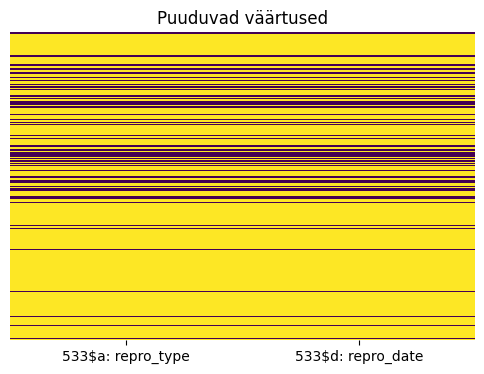

In [465]:
# nagu näha, siis kasutatakse neid kahte tulpa alati koos.
missing_values_heatmap(df)

In [468]:
### igaks juhuks topelkontroll, ega pole kirjeid, kus on täidetud nii 533$a kui 533$d
### nagu näha, siis 52 juhul on aasta puudu, aga see ei ole takistuseks
rows_with_only_533a = df[df['533$a'].notna() & df['533$d'].isna()]
rows_with_only_533d = df[df['533$a'].isna() & df['533$d'].notna()]
print("Kirjeid, kus ainult repro märge:", len(rows_with_only_533a))
print("Kirjeid, kus ainult repro aasta:", len(rows_with_only_533d))

Kirjeid, kus ainult repro märge: 52
Kirjeid, kus ainult repro aasta: 0


In [460]:
df["533$a"].value_counts()

Elektrooniline reproduktsioon                                                                                                 47183
Elektrooniline reproduktsioon; Elektrooniline reproduktsioon                                                                    307
aElektrooniline reproduktsioon                                                                                                    7
Elektrooniline reproduktsioon; Elektrooniline reproduktsioon; Elektrooniline reproduktsioon                                       5
 Elektrooniline reproduktsioon                                                                                                    3
Elektrooniline reproduktsioon. Tartu : Tartu Ülikooli Raamatukogu, 2015                                                           3
Elektrooniline reroduktsioon                                                                                                      2
9789916503232 (pdf)Elektrooniline reproduktsioon                            

In [473]:
df["533$d"].value_counts()[:20]

2022         12238
2023          8007
2019-2021     3992
2019          3240
2021          3074
2018          2286
2020          2155
2017          1931
2016          1790
2012          1279
2015           828
2011           706
2019.0         666
2018.0         630
2020.0         588
2014           571
2024           537
2023.0         534
2021.0         534
2013           518
Name: 533$d, dtype: int64

In [464]:
# 533$a saab muuta booleaniks (digiteeritud jah/ei)
# 533$d on seega sisuliselt digiteerimise aasta

#### 533$a

In [474]:
def clean_533a(entry):
    if type(entry) == str:
        return True
    else:
        return False

In [476]:
df["533$a_cleaned"] = df["533$a"].apply(clean_533a)

In [477]:
df

,533$a,533$d,533$a_cleaned
0,Elektrooniline reproduktsioon,2023,True
1,NaN,NaN,False
2,Elektrooniline reproduktsioon,2021,True
3,NaN,NaN,False
4,NaN,NaN,False
...,...,...,...
219990,NaN,NaN,False
219991,NaN,NaN,False
219992,NaN,NaN,False
219993,NaN,NaN,False


#### 533$d

In [545]:
match = re.match(r"\d{4}(\.0|\w+)", "2022.0")
match.string
match.string[:4]

'2022'

In [507]:
pattern_533d = re.compile(r"^(\d{4}(-\d{4})?)(\;\s\d{4}(-\d{4})?)*")

In [508]:
re.findall("\d{4}", "2012; 2013")

['2012', '2013']

In [588]:
def clean_533d(entry, pattern=pattern_533d, min_year=2000, max_year=2024):
    if type(entry) != str:
        entry = str(entry)
    match = re.match(pattern, entry)
    if match:
        year = match.string
        if re.match(r"\d{4}(\.0|\w+)", year):
            year = year[:4]
        return year

In [647]:
# näited
sample = df["533$d"].loc[df["533$d"].notna()].sample().values[0]
print(sample, "\t-\t", clean_533d(sample))

2019-2021 	-	 2019-2021


In [648]:
df["533$d_cleaned"] = df["533$d"].apply(clean_533d)

In [657]:
df.sample(10)

,533$a,533$d,533$a_cleaned,533$d_cleaned
54184,NaN,NaN,False,None
5315,NaN,NaN,False,None
138060,NaN,NaN,False,None
27424,NaN,NaN,False,None
182521,NaN,NaN,False,None
133148,NaN,NaN,False,None
177666,NaN,NaN,False,None
171960,NaN,NaN,False,None
134013,NaN,NaN,False,None
79213,NaN,NaN,False,None


### Sisu- ja žanrimärksõnad (650, 651, 655)

#### Sisumärksõnad (650 a, 0)

In [185]:
df = df_main[["650$a", "650$0"]]

Täidetus:
650$a: subject_topic: 96 %
650$0: subject_topic_thesaurus: 95 %


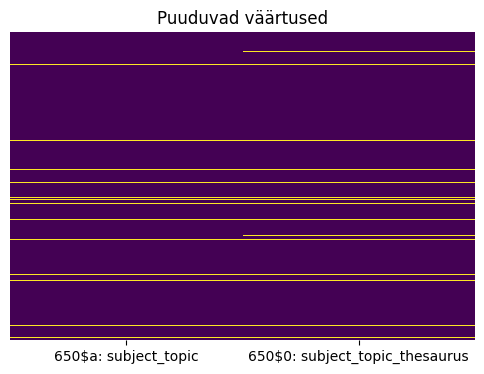

In [186]:
missing_values_heatmap(df)

In [203]:
# kui palju on kannete osakaal, kus märksõnale on EMS lisamata?
print(round(len(df.loc[(df["650$a"].notna()) & (df["650$0"].isna())]) / len(df), 2)*100, "%")
# väga vähe

1.0 %


In [204]:
# kontrollime igaks juhuks, kas on ridu, kus on EMS lingid, aga märksõna ennast mitte
print(len(df.loc[(df["650$a"].isna()) & (df["650$0"].notna())]))
# ei ole

0


In [206]:
### Märksõnade ja linkide dubleerimine tundub veidi mõttetu.
### Äkki hoopis tõstaks EMS IDd märksõnade järele nurksulgudesse (usuõpetus [022767]) ja lisaks seletuse dokumentatsiooni?

#### Žanrimärksõnad (655 a, 0)

In [208]:
df = df_main[["655$a", "655$0"]].copy()

Täidetus:
655$a: subject_genre: 85 %
655$0: subject_genre_thesaurus: 58 %


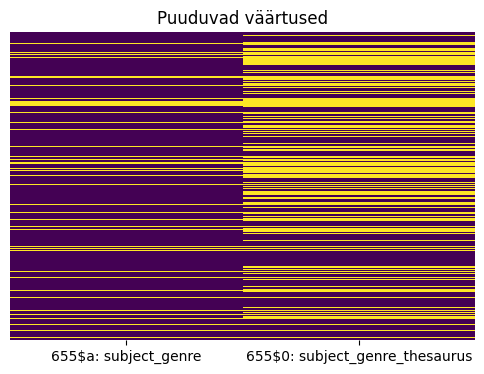

In [209]:
missing_values_heatmap(df)

In [210]:
# kontrollime igaks juhuks, kas on ridu, kus on EMS lingid, aga märksõna ennast mitte
df.loc[(df["655$a"].isna()) & (df["655$0"].notna())]

,655$a,655$0


In [216]:
# samas on väga palju kandeid, kus EMS lingid puuduvad
print(len(df.loc[(df["655$a"].notna()) & (df["655$0"].isna())]))

# näiteks
df.loc[(df["655$a"].notna()) & (df["655$0"].isna())].sample(10)

# nendel märksõnadel peaks kõigil EMS id olema - kas hakkame seda tööd ise tegema?

60411


,655$a,655$0
124826,nimestikud,NaN
78699,õppekavad,NaN
36890,statistilised andmed,NaN
192585,kokaraamatud,NaN
119950,stenogrammid,NaN
7278,töövihikud,NaN
107226,kokaraamatud,NaN
109320,palveraamatud,NaN
97370,õppekavad; kavandid (projektid),NaN
166758,infotrükised,NaN


#### Kohamärksõnad (651 a, 0)

In [217]:
df = df_main[["651$a", "651$0"]].copy()

Täidetus:
651$a: subject_geographic_name: 30 %
651$0: subject_geographic_thesaurus: 30 %


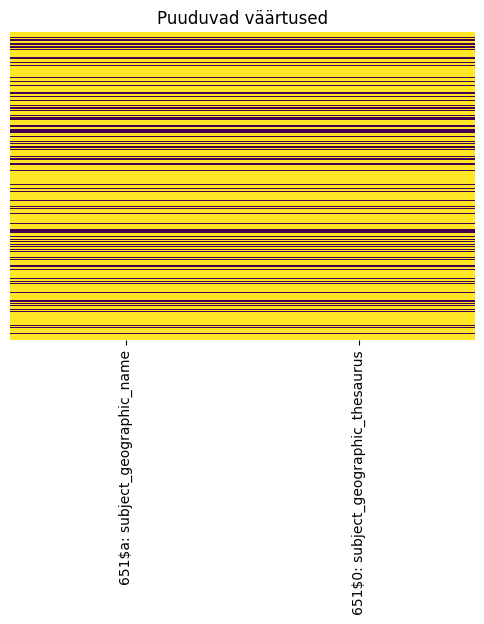

In [218]:
missing_values_heatmap(df)

In [219]:
# kontrollime igaks juhuks, kas on ridu, kus on EMS lingid, aga märksõna ennast mitte
df.loc[(df["651$a"].isna()) & (df["651$0"].notna())]
# ei ole

,651$a,651$0


In [ ]:
# tundub, et kõik on juba normkujul ja harmoniseerida pole vaja
df.loc[df["651$a"].notna()].sample(10)

,651$a,651$0
158832,NSV Liit,https://ems.elnet.ee/id/EMS131700
32556,Eesti (riik),https://ems.elnet.ee/id/EMS131705
35066,Eesti (riik),https://ems.elnet.ee/id/EMS131705
153274,Venemaa; Peterburi,https://ems.elnet.ee/id/EMS131683; https://ems...
41337,Ida-Virumaa,https://ems.elnet.ee/id/EMS131716
35728,NSV Liit,https://ems.elnet.ee/id/EMS131700
111992,Riia,https://ems.elnet.ee/id/EMS133101
138066,Järvamaa,https://ems.elnet.ee/id/EMS131723
186993,Heimtali,https://ems.elnet.ee/id/EMS135497
135714,Tartu,https://ems.elnet.ee/id/EMS131949


### Seeriaandmed (490a)

In [148]:
df = df_main["490$a"].copy()

Täidetus:
490$a: series_statement: 21 %


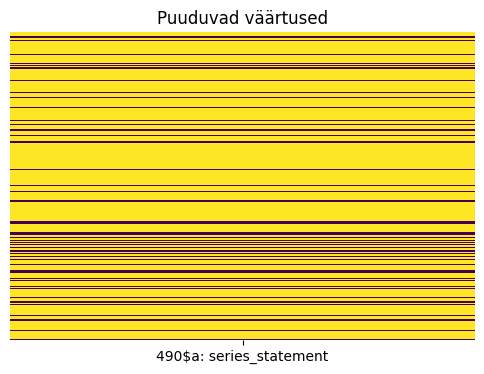

In [149]:
missing_values_heatmap(df.to_frame())

In [156]:
df.sample(10)

63046                                                   NaN
169629                                                  NaN
6342                                                    NaN
86663                                                   NaN
27240                             Eesti riikline statistika
108199                                                  NaN
199446                                  Harlequin romantika
186702                                                  NaN
40177     Teaduse saavutusi ja eesrindlikke kogemusi põl...
135641              Saaremaa Merekultuuri Seltsi toimetised
Name: 490$a, dtype: object

### Üldmärkused (500a)

In [161]:
df = df_main["500$a"].copy()

Täidetus:
500$a: general_note: 29 %


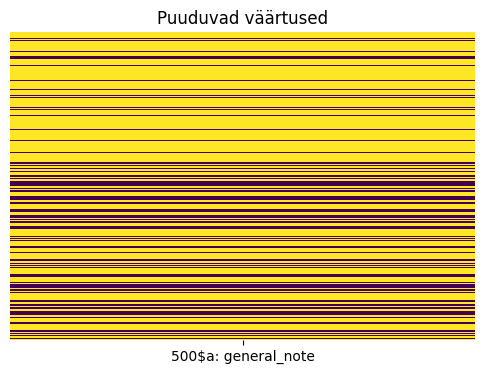

In [162]:
missing_values_heatmap(df.to_frame())

In [163]:
def clean_500a(entry):
    tiraaz = None
    hind = None
    kirjastiil = None
    if type(entry) == str:

        pattern_500a_tiraaz = re.compile(r"(?P<tiraaz>\d+(\.\d+)?)\s(eks\.?)")
        match = re.search(pattern_500a_tiraaz, entry)
        if match:
            tiraaz = int(match.groupdict()["tiraaz"].replace('.', ''))

        pattern_500a_hind = re.compile(r"(?P<rubla>\d\s(rbl\.?|rubla))?\s*(?P<kop>\d{1,2}\skop)")
        match = re.search(pattern_500a_hind, entry)
        if match:
            hind = match.string[match.span()[0]:match.span()[1]]

        pattern_500a_kirjastiil = re.compile(r"(?P<kirjastiil>[Ff]raktuur|[Aa]ntiikva)")
        match = re.search(pattern_500a_kirjastiil, entry)
        if match:
            kirjastiil = (match.groupdict()["kirjastiil"].lower()[0])

    return (tiraaz, hind, kirjastiil)

In [165]:
df = df.to_frame()
df[["tiraaz", "hind", "kirjastiil"]] = df["500$a"].apply(clean_500a).to_list()

Täidetus:
tiraaz: 5 %
hind: 2 %
kirjastiil: 6 %


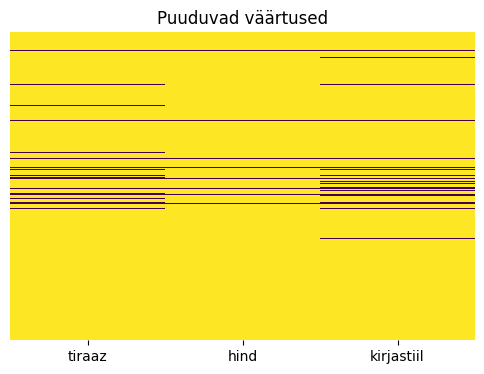

In [166]:
# tiraazi, hinna ja kirjastiili täituvus eraldi on väga madal. Kas jätta sisse või ei?
missing_values_heatmap(df[["tiraaz", "hind", "kirjastiil"]])

In [ ]:
# millised on kõige sagedasemad üldmärkused, mis ei sisalda hinda, tiraazi ega kirjastiili?
df.loc[(df["tiraaz"].isna()) & (df["hind"].isna()) & (df["kirjastiil"].isna()), "500$a"].value_counts()[:20]
# siit vist väga midagi enam välja ei võta

Päistiitel                                                     2535
Kaanel autor märkimata                                         2047
Kirjeldatud trükise alusel                                     1172
Mimeograafpaljundus                                             909
Kaanel autorid märkimata                                        789
Kaanel ainult seeriapealkiri                                    760
Kirjeldatud kaane järgi                                         468
Kaanel pealkiri ja autor märkimata                              450
Kaanel pealkiri märkimata                                       445
Autor näidatud tagakaanel                                       417
Autor näidatud tiitellehe pöördel                               414
Autorid näidatud tiitellehe pöördel                             369
Ilmumisaasta allikas: Eesti raamatute üldnimestik 1918-1923     319
Tekst lehe ühel küljel                                          303
Autor näidatud kaanel                           

### Algupärandi märkus (534c)

In [91]:
df = df_main["534$c"].copy().to_frame()

Täidetus:
534$c: original_version_distribution: 6 %


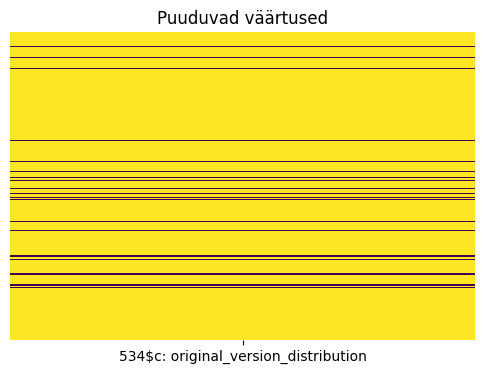

In [65]:
missing_values_heatmap(df)

In [74]:
pattern_534c = re.compile(r"((?P<place>[A-ZÕÄÖÜ]\w+(\s\;\s[A-ZÕÄÖÜ]\w+)?)(\s?\:\s((?P<publisher>((([A-Z&]+\s)?[A-ZÕÄÖÜk]\w+(\s|\-)?)+)|(s\.\s?n\.)|(([A-ZÕÄÖÜ]\.\s)+[A-ZÕÄÖÜ]\w+))))?)?(,\s)?c?(?:([IVXLCDM]+\s)+)?((?P<range>\d{4}\-\d{4})|(?P<year>\d{4}))?")

In [103]:
def clean_534c(entry, pattern=pattern_534c):
    year = None
    place = None
    publisher = None
    if type(entry) == str:
        entry = entry.lstrip().replace('[', '').replace(']', '')
        match = re.search(pattern, entry)
        if match:
            matchgroups = match.groupdict()
            if matchgroups["year"]:
                year = int(matchgroups["year"])
            place = matchgroups["place"]
            publisher = matchgroups["publisher"]
            if matchgroups["range"]:
                year = int(matchgroups["range"].split("-")[0])

    return (year, place, publisher)

In [104]:
df[["original_distribution_year", "original_distribution_place", "original_distribution_publisher"]] = df["534$c"].apply(clean_534c).to_list()
df = df.convert_dtypes()

In [105]:
df.loc[df["534$c"].notna()].sample(10)

,534$c,original_distribution_year,original_distribution_place,original_distribution_publisher
105859,1887,1887.0,None,None
103155,"Tartu : Odamees, 1925",1925.0,Tartu,Odamees
21368,1931/1932,1931.0,None,None
194132,"Tallinn : Koolibri, 2011",2011.0,Tallinn,Koolibri
85779,1932,1932.0,None,None
169696,"Tallinn : Varrak, 2012. 2.tr; Tallinn : Varrak...",2012.0,Tallinn,Varrak
29064,"Göteborg : Orto, 1951",1951.0,Göteborg,Orto
185854,"Tartu : Noor-Eesti Kirjastus, 1935",1935.0,Tartu,Noor-Eesti Kirjastus
162123,"Tallinn : Varrak, 2005",2005.0,Tallinn,Varrak
166944,"Tallinn : Meediatera, 2012",2012.0,Tallinn,Meediatera


In [106]:
regex_coverage(df, "534$c", pattern_534c)

Regex katab 13787 kirjet 13787 kirjest
Kaetus:  100.0 %


In [116]:
### katmata jääavad segased kirjed, kirillitsas kohanimed jne
df.loc[(df["534$c"].notna()) & (df["original_distribution_year"].isna()) & (df["original_distribution_place"].isna()) & (df["original_distribution_publisher"].isna())].sample(10)

,534$c,original_distribution_year,original_distribution_place,original_distribution_publisher
5215,"kirjastus osaühing ""Loodus"", 1940",NaN,None,None
119960,"(1982), nr. 7-8",NaN,None,None
109330,"Ревель : F. Kluge, 1903",NaN,None,None
37792,nr. 1-35,NaN,None,None
113378,3. leht,NaN,None,None
68455,Москва 1968,NaN,None,None
106008,"Ревель, 1896",NaN,None,None
110518,"5 : 1916, 1916; 1915",NaN,None,None
141733,"Горький : Волго-Вятское книжное издательство, ...",NaN,None,None
592,nr. 15-23,NaN,None,None


### Autoriõiguse info (542l)

In [117]:
df = df_main["542$l"].copy()

Täidetus:
542$l: copyright_status: 13 %


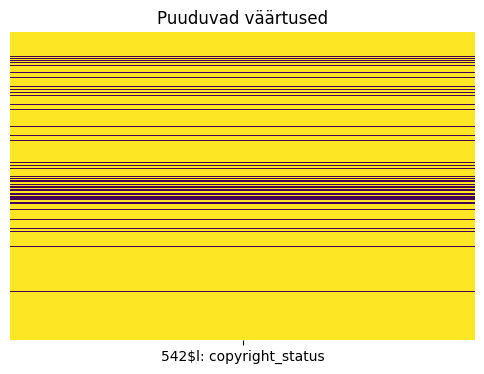

In [118]:
missing_values_heatmap(df.to_frame())

In [120]:
### jätame sisse, aga kas võiks kasutada lühendeid/koode?
df.value_counts()

Vabakasutus                 27178
Orbteos                       643
Osaline orbteos                23
Kehtiv autoriõigus              1
Vabakasutus; Vabakasutus        1
Name: 542$l, dtype: int64

### Isikumärksõna (600)

In [10]:
df = df_main["600"].copy()

Täidetus:
600: subject_person: 7 %


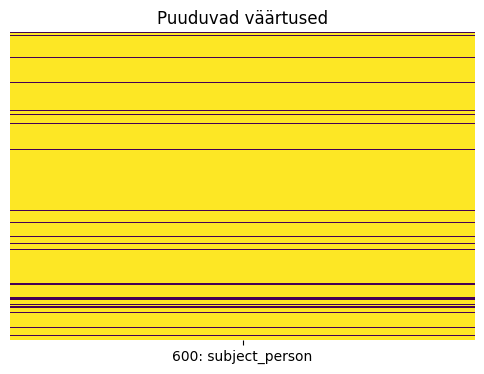

In [11]:
missing_values_heatmap(df.to_frame())

In [15]:
# tundub, et siin on üldiselt korras?
df.loc[df.notna()].sample(10)

135871                                  Siib, Liina (1963-)
189990                                   Paju, Aili (1938-)
17814                            Laigo, Arkadio (1901-1944)
96906                                 Pieder, Jüri [omanik]
162963    Särak, Voldemar (1911-1947); Hellat, Toomas (1...
8510                       Baer, Karl Ernst von (1792-1876)
193277                     Hagen-Schwarz, Julie (1824-1902)
168649                          Grenzstein, Ado (1849-1916)
123627                              Vare, Vello (1923-2007)
172594    Wühner, Hans (1836-1911); Kissa, Jaak (1843-19...
Name: 600, dtype: object

### Ajamärksõna (648a)

In [135]:
df = df_main["648$a"].copy()

Täidetus:
648$a: subject_chronological_term: 5 %


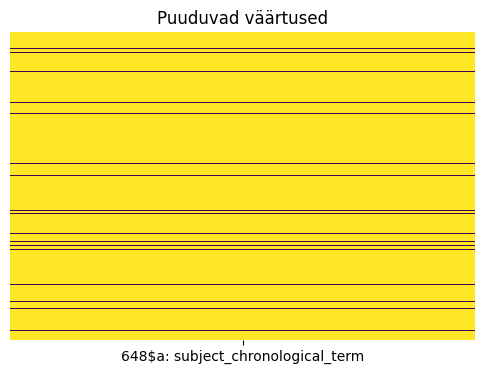

In [137]:
missing_values_heatmap(df.to_frame())

In [143]:
df.value_counts()[:100].sum() / len(df[df.notna()])

0.875974972143653

In [145]:
pattern_648a = re.compile(r"(?P<century>\d{1,2}\. saj\.?(\s(((1|2)\.)\spool)|\salgus|\slõpp)?)|(?P<decade>\d{4}\-ndad)|(?P<range>\d{4}\-\d{4})|(?P<year>\d{4})")

In [150]:
def clean_648a(entry, pattern=pattern_648a):
    year = None
    range = None
    decade = None
    century = None
    if type(entry) == str:
        entry_split = entry.split("; ")
        for part in entry_split:
            match = re.search(pattern, entry)
            if match:
                if century
                century, decade, range, year = match.groupdict().values()

    return (year, range, decade, century)


In [153]:
df = df.to_frame()
df[["year", "range", "decade", "century"]] = df["648$a"].apply(clean_648a).to_list()

In [157]:
df.loc[df["648$a"].notna()].sample(10)

,648$a,year,range,decade,century
96531,1980-ndad,None,None,1980-ndad,None
144352,1990-ndad; 2000-ndad,None,None,1990-ndad,None
145829,1810-ndad,None,None,1810-ndad,None
5298,1918-1940,None,1918-1940,None,None
1140,20. saj,None,None,None,20. saj
57683,1970-ndad,None,None,1970-ndad,None
58851,1940-1945,None,1940-1945,None,None
9828,1980-ndad; 1990-ndad,None,None,1980-ndad,None
181555,18. saj; 19. saj; 20. saj,None,None,None,18. saj
172218,20. saj. 2. pool; 21. saj. algus,None,None,None,20. saj. 2. pool


### Isikunime täiendkirje e. contributor (700)

In [8]:
df = df_main["700"].copy()

In [9]:
### näiteid; võib kontrollida, kas siin on kõik korras ja kas peaks täiendama. kas VIAFi tõstaksime samasse tulpa nt looksulgudesse või on mõni parem variant?
for val in df.loc[df.notna()].sample(10).values:
    print(val)

Jürjo, Merike (1959-) [koostaja]; Nõmm, Aart (1976-) [koostaja]; Ojalo, Hanno (1961-) [koostaja]; Arumäe, Ivika (1961-) [toimetaja]; Garshnek, Jan (1981-) [kujundaja]
Lepp, Mart (1947-) [teksti autor]; Lepp, Mart (1947-) [kujundaja]
Kallo, Ferdinand (1912-1987) [tõlkija]
Lepasalu, Rajur (1917-1942) [autor]
Randmaa, Aldo (1969-) [tõlkija]; Maran, Olav (1933-) [toimetaja]; Kurg, Ingmar (1955-) [toimetaja]; Sildre, Tiina (1959-) [kujundaja]
Bjömson, B: "Hädaohtlik kosimine"; Kielland, Alexander L (1849-1906): "Kolletanud Lehed"; Strindberg, August (1849-1912): "Üle pilvede"; Bjömson, B: "Kõrb"; Kielland, Alexander L (1849-1906): "Rahvapidu"; Kielland, Alexander L (1849-1906): "Pealelõunane unenägu"; Kielland, Alexander L (1849-1906): "Pidutuju"; Strindberg, August (1849-1912): "Rätsepa tantsupidu"; Strindberg, August (1849-1912): "Võitlus iseseisvuse eest"; Bjömson, B: "Thrond"
Krusten, Reet (1934-2021) [koostaja]; Leete, Eve [toimetaja]; Saar, Olivia (1931-) [toimetaja]; Saare, Krista (1

### Kollektiivi täiendkirje (710 a, b)

In [ ]:
df = df_main[["710$a", "710$b"]]

Täidetus:
710$a: added_corporate_name: 30 %
710$b: added_corporate_sub_unit: 11 %


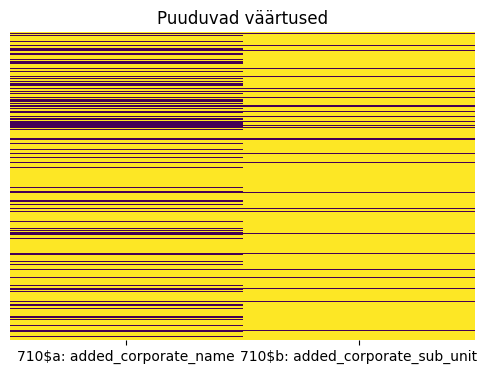

In [ ]:
missing_values_heatmap(df)

In [ ]:
len(df.loc[(df["710$a"].isna()) & (df["710$b"].notna())])
# kui on 710b, siis alati on ka 710a

0

In [ ]:
df.loc[df["710$a"].notna()].sample(10)

,710$a,710$b
20031,NSV Liidu Kõrg- ja Keskerihariduse Ministeerium,Ühiskonnateaduste Õpetamise Valitsus
15124,Eesti NSV Põllumajandusministeerium,Põllumajandusliku Propaganda Valitsus
87208,Eesti NSV Riiklik Hariduskomitee,NaN
91417,Eesti NSV Statistika Keskvalitsus,NaN
56276,Eesti NSV Haridusministeerium,NaN
42236,Eesti Informatsiooni Instituut,NaN
47423,Eesti NSV Punase Risti Selts,NaN
26495,Tehniline Kirjastus,NaN
76171,Eesti NSV Rahvamajanduse Nõukogu; Eesti NSV Am...,"Tööliskaadri, töö ja töötasu osakond; Töökaits..."
78334,Eesti Tarbijate Kooperatiivide Vabariiklik Liit,NaN


In [ ]:
### mulle tunduvad need kirjed piisavalt korrektsed ja samas liiga varieeruvad, et normima hakata.
### Jääb küsimus, kas tõsta allüksus organisatsiooni järele, nt sulgudesse.
### Mõnel puhul võib olla kadunud täpne seos a ja b väärtuste vahel, kui 710a sisaldab mitut org-i, kuid nt ainult ühel neist on lisatud allüksus

### Vabapealkiri (740a)

In [240]:
df = df_main["740$a"].copy()

Täidetus:
740$a: uncontrolled_related_title: 7 %


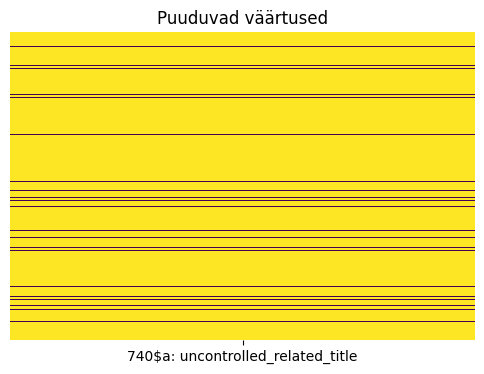

In [241]:
missing_values_heatmap(df.to_frame())

In [244]:
### seda pole vist mõtet harmoniseerida, aga võib sisse jätta
df.value_counts()[:30]

ELIKbaas                                                                                                                      1174
Eesti trükise punane raamat II, 1851-1917. Rariteedid                                                                          716
Eesti trükise punane raamat II, 1851-1917. Kultuuriloolised valikud                                                            515
Eesti trükise punane raamat I, 1535-1850                                                                                       510
Peep Sürje kogu                                                                                                                175
Sada rooga                                                                                                                     167
EV 100                                                                                                                         155
Eesti trükise punane raamat II, 1851-1917. Kultuuriloolised valikud; Eesti trükise 

### Hierarhiline kohanimi (752 c, d)

In [245]:
df = df_main[["752$c", "752$d"]]

Täidetus:
752$c: added_intermediate_political_jurisdiction: 32 %
752$d: added_city: 2 %


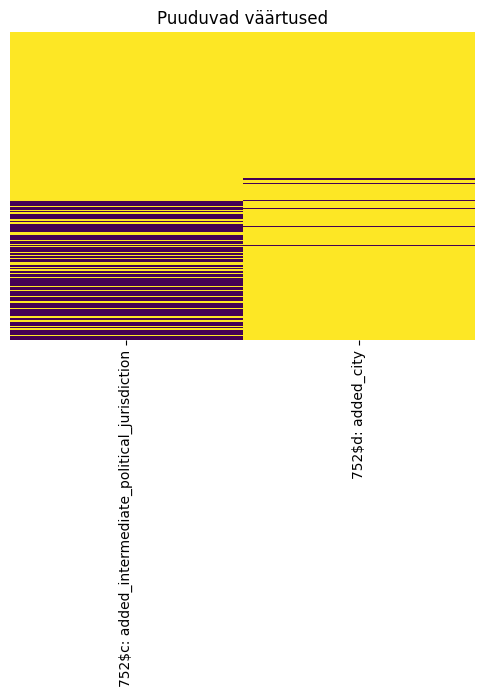

In [246]:
missing_values_heatmap(df)

In [267]:
df["752$c"].value_counts()[:20]

Harjumaa              55873
Tartumaa               8991
Pärnumaa               1230
Viljandimaa             640
Järvamaa                616
Lääne-Virumaa           559
Võrumaa                 547
Jõgevamaa               496
Ida-Virumaa             438
Saaremaa                407
Raplamaa                399
Läänemaa                330
Põlvamaa                300
Valgamaa                297
Hiiumaa                 140
Harjumaa; Harjumaa       27
Leningradi oblast        16
Venemaa                   9
Berliin                   6
Tallinn                   4
Name: 752$c, dtype: int64

In [268]:
df["752$d"].value_counts()[:20]

Tartu                              1800
Tallinn                            1210
Riia                                183
Viljandi                            181
Kuressaare                          157
Paide                               117
Pärnu                                93
Võru                                 89
Peterburi                            84
Rakvere                              74
Valga                                61
Narva                                48
Tallinn; Tallinn, trükkimiskoht      35
Leningrad                            34
Moskva                               33
Tallinn, trükkimiskoht               29
Tartu; Tartu, trükkimiskoht          27
Põltsamaa                            23
Tartu (trükkimiskoht)                22
Aegviidu                             19
Name: 752$d, dtype: int64

In [ ]:
### need väljad täidetakse põhimõtteliselt ainult Eesti puhul. Mida teeme?

### Elektrooniline juurdepääs e. URI (856$u)

In [ ]:
df = df_main["856$u"].copy().to_frame()

Täidetus:
856$u: electronic_access_URI: 37 %


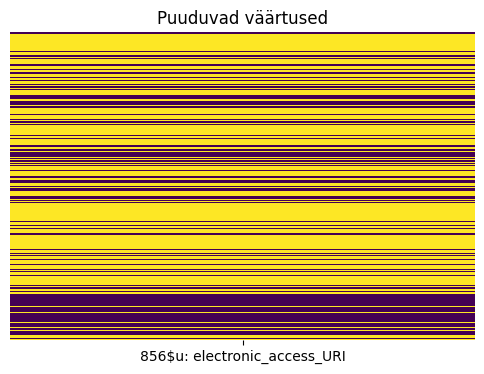

In [ ]:
missing_values_heatmap(df)

In [ ]:
### siin tundub kõik korras olevat
df.sample(10)

,856$u
47121,http://www.digar.ee/id/nlib-digar:652941
46305,https://www.digar.ee/id/nlib-digar:101448; htt...
108600,NaN
1088,NaN
158649,NaN
87296,NaN
215714,http://www.digar.ee/id/nlib-digar:886408
11676,NaN
186584,NaN
51718,NaN


In [ ]:
from urllib.parse import urlparse

def is_valid_url(url):
    parsed_url = urlparse(url)
    return bool(parsed_url.scheme and parsed_url.netloc)

def validate_856u(entry):
    if type(entry) == str:
        valid = []
        entry_split = entry.split("; ")
        for url in entry_split:
            valid.append(is_valid_url(url))
        if False not in valid:
            return True
        else:
            return False
    else:
        return None

In [ ]:
bool(
    urlparse("http://kivike.kirmus.ee/AR-17101-53943-52626").scheme and
    urlparse("http://kivike.kirmus.ee/AR-17101-53943-52626").netloc
)
    

True

In [ ]:
df["valid_url"] = df["856$u"].apply(validate_856u)

In [ ]:
def clean_856u(entry):
    if type(entry) == str:
        entry_split = entry.split("; ")
        return "; ".join([url.strip().lstrip() for url in entry_split if is_valid_url(url.strip().lstrip())])

In [ ]:
df["856$u_cleaned"] = df["856$u"].apply(clean_856u)

In [ ]:
df.loc[df["856$u"].notna()].sample(10)

,856$u,valid_url,856$u_cleaned
124826,https://www.digar.ee/id/nlib-digar:273420,True,https://www.digar.ee/id/nlib-digar:273420
122996,http://kivike.kirmus.ee/AR-23313-36137-62562,True,http://kivike.kirmus.ee/AR-23313-36137-62562
212539,http://www.digar.ee/arhiiv/nlib-digar:913574; ...,True,http://www.digar.ee/arhiiv/nlib-digar:913574; ...
64015,http://hdl.handle.net/10062/55596,True,http://hdl.handle.net/10062/55596
126206,https://www.digar.ee/id/nlib-digar:103547,True,https://www.digar.ee/id/nlib-digar:103547
217886,https://www.digar.ee/arhiiv/nlib-digar:984688,True,https://www.digar.ee/arhiiv/nlib-digar:984688
210136,http://www.digar.ee/arhiiv/nlib-digar:680990,True,http://www.digar.ee/arhiiv/nlib-digar:680990
169851,http://ellu.keskraamatukogu.ee/book/9789949495...,True,http://ellu.keskraamatukogu.ee/book/9789949495...
205004,https://www.digar.ee/id/nlib-digar:602148,True,https://www.digar.ee/id/nlib-digar:602148
165870,http://www.digar.ee/id/nlib-digar:210030,True,http://www.digar.ee/id/nlib-digar:210030
